<a href="https://www.kaggle.com/code/kenny3s/iht-pyiqa-sadcnn?scriptVersionId=156273750" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
data_dir = "/kaggle/input/fvc2000-dec/dataset_ori"
half_dir = "/kaggle/input/fvc2000-sadcnn"
re_dir = "/kaggle/input/fvc2000-dec/dataset_re"

iht_dir = "/kaggle/input/fvc2000-dec/dataset_ori"
p = []
for person in os.listdir(iht_dir):
    p.append(person)
p.sort()
p

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009']

In [2]:
!pip install pyiqa
#https://www.kaggle.com/discussions/questions-and-answers/426884
!sed -i 's/from scipy.spatial import ConvexHull, QhullError/from scipy.spatial import ConvexHull/g' /opt/conda/lib/python3.10/site-packages/skimage/morphology/convex_hull.py

  Obtaining dependency information for pyiqa from https://files.pythonhosted.org/packages/c6/ae/bff1d01ccb94051b8c06c152680336aa142174f80917968015e8b6dcc2d7/pyiqa-0.1.8-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 12.6 MB/s eta 0:00:00
  Obtaining dependency information for tb-nightly from https://files.pythonhosted.org/packages/b8/21/7abd6309a766d195f0ce4ded6fae18ee5f35abe86beb2192e915d86c268f/tb_nightly-2.16.0a20231223-py3-none-any.whl.metadata
  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.meta

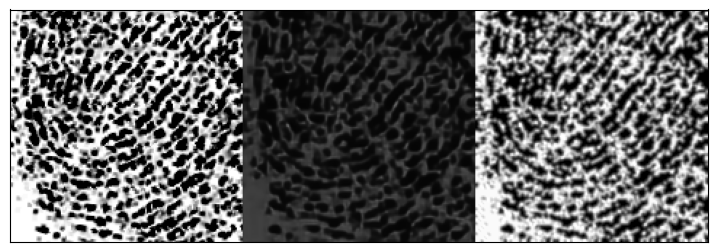

In [3]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
for person in p[0:1]:
    for img in os.listdir(os.path.join(data_dir, person))[0:1]:
        color = Image.open(f"{data_dir}/{person}/{img}")
        iht = Image.open(f"{half_dir}/{person}/{img}")  # Assuming this returns a NumPy array
        sa = Image.open(f"{re_dir}/{person}/{img}")
        
        color = color.convert('L').convert("RGB")
        iht = iht.convert("RGB")
        sa = sa.convert("RGB")
        
        # Convert the images to NumPy arrays and stack them horizontally
        rst = np.hstack([np.array(color), np.array(iht), np.array(sa)])

        # Convert the result back to a PIL image
        rst = Image.fromarray(rst)

        plt.figure(figsize=(9, 9))  
        plt.xticks([]) 
        plt.yticks([]) 
        plt.imshow(rst)
        plt.show()


In [4]:
import os
import torch
from PIL import Image
import pyiqa

from tqdm import tqdm
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

psnr_metric = pyiqa.create_metric('psnr', device=device)
ssim_metric = pyiqa.create_metric('ssim', device=device)
clip_metric = pyiqa.create_metric('clipiqa', device=device)
ms_ssim_metric = pyiqa.create_metric('ms_ssim', device=device)
lpips_metric = pyiqa.create_metric('lpips', device=device)
dists_metric = pyiqa.create_metric('dists', device=device)
fid_metric = pyiqa.create_metric('fid', device=device)

def calculate_quality(x, y, z):
    quality = {
        'psnr1': psnr_metric(x, y).item(),
        'psnr2': psnr_metric(x, z).item(),
        'ssim1': ssim_metric(x, y).item(),
        'ssim2': ssim_metric(x, z).item(),
        "ms_ssim1": ms_ssim_metric(x, y).item(),
        "ms_ssim2": ms_ssim_metric(x, z).item(),
        "clip_iqa1": clip_metric(y).item(),
        "clip_iqa2": clip_metric(z).item(),
        "lpips1": lpips_metric(x, y).item(),
        "lpips2": lpips_metric(x, z).item(),
        "dists1": dists_metric(x, y).item(),
        "dists2": dists_metric(x, z).item(),
    }

    return quality

def calculate_fid(x, y, z):
    quality = {
        'fid1': fid_metric(x, y).item(),
        'fid2': fid_metric(x, z).item(),
    }
    return quality

# Initialize a dictionary to store the average quality for each class
average_quality = {}

for person in p:
    quality_sum = {}
    fid_sum = {}
    
    quality_fid = calculate_fid(f"{data_dir}/{person}",f"{half_dir}/{person}",f"{re_dir}/{person}" )
    for key, value in quality_fid.items():
        fid_sum[key] = quality_sum.get(key, 0) + value
        
    for img in os.listdir(os.path.join(data_dir, person)):
        color = Image.open(f"{data_dir}/{person}/{img}").resize((250,250))
        iht = Image.open(f"{half_dir}/{person}/{img}").resize((250,250))
        sa = Image.open(f"{re_dir}/{person}/{img}").resize((250,250))
        
        color = color.convert('L').convert("RGB")
        iht = iht.convert("RGB")
        sa = sa.convert("RGB")

        # Calculate the quality for this image
        quality = calculate_quality(color, iht, sa)

        # Update the sum of the quality
        for key, value in quality.items():
            quality_sum[key] = quality_sum.get(key, 0) + value
    
    
    # Calculate the average quality for this class
    num_images = len(os.listdir(os.path.join(data_dir, person)))
    classes = int(person)
    average_quality[classes] = {key: value / num_images for key, value in quality_sum.items()}
    average_quality[classes].update({key: value for key, value in fid_sum.items()})


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-24 08:26:37,081 INFO: Metric [PSNR] is created.
2023-12-24 08:26:37,082 INFO: Metric [SSIM] is created.
100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 137MiB/s]
2023-12-24 08:26:42,679 INFO: Metric [CLIPIQA] is created.
2023-12-24 08:26:42,680 INFO: Metric [MS_SSIM] is created.
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 284MB/s]


Downloading: "https://github.com/chaofengc/IQA-Toolbox-Python/releases/download/v0.1-weights/LPIPS_v0.1_alex-df73285e.pth" to /root/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth


100%|██████████| 5.87k/5.87k [00:00<00:00, 2.43MB/s]


Loading pretrained model LPIPS from /root/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth


2023-12-24 08:26:47,829 INFO: Metric [LPIPS] is created.
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 313MB/s]


Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/DISTS_weights-f5e65c96.pth" to /root/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth


100%|██████████| 12.0k/12.0k [00:00<00:00, 5.11MB/s]
2023-12-24 08:26:51,782 INFO: Metric [DISTS] is created.
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading pretrained model DISTS from /root/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 91.2M/91.2M [00:00<00:00, 291MB/s]
2023-12-24 08:26:53,128 INFO: Metric [FID] is created.


Loading pretrained model Inception3 from /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
compute FID between two folders


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00000


FID 00000: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00000


FID 00000: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00000


FID 00000: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00000


FID 00000: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00001


FID 00001: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00001


FID 00001: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00001


FID 00001: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00001


FID 00001: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00002


FID 00002: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00002


FID 00002: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00002


FID 00002: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00002


FID 00002: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00003


FID 00003: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00003


FID 00003: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00003


FID 00003: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00003


FID 00003: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00004


FID 00004: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00004


FID 00004: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00004


FID 00004: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00004


FID 00004: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00005


FID 00005: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00005


FID 00005: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00005


FID 00005: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00005


FID 00005: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00006


FID 00006: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00006


FID 00006: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00006


FID 00006: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00006


FID 00006: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00007


FID 00007: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00007


FID 00007: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00007


FID 00007: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00007


FID 00007: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00008


FID 00008: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00008


FID 00008: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00008


FID 00008: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00008


FID 00008: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00009


FID 00009: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Found 80 images in the folder /kaggle/input/fvc2000-sadcnn/00009


FID 00009: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


compute FID between two folders
Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_ori/00009


FID 00009: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Found 80 images in the folder /kaggle/input/fvc2000-dec/dataset_re/00009


FID 00009: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


## 后缀为1代表P3解密图像
## 后缀为2代表SADCNN逆半调

In [5]:
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame(average_quality)

# Transpose the DataFrame so that each row corresponds to a person
df = df.transpose()

# Display the DataFrame
print(df)

# Save the DataFrame as a CSV file
df.to_csv('fingerprint_quality_metrics.csv')

      psnr1      psnr2     ssim1     ssim2  ms_ssim1  ms_ssim2  clip_iqa1  \
0  5.491574  13.319162  0.158661  0.620498  0.350536  0.859459   0.206885   
1  4.966246  12.522505  0.165530  0.612476  0.353605  0.840830   0.252670   
2  5.106581  13.205681  0.177049  0.684820  0.373387  0.893003   0.279861   
3  4.876860  12.739117  0.181500  0.647691  0.375157  0.877642   0.296863   
4  4.320226  11.093058  0.184674  0.525252  0.365075  0.734755   0.260801   
5  4.574393  11.681334  0.181518  0.548320  0.360161  0.773025   0.259383   
6  4.520852  11.640612  0.176078  0.590548  0.356680  0.807685   0.330135   
7  4.486714  11.430204  0.188443  0.530485  0.368485  0.760400   0.259650   
8  5.061955  12.423585  0.162342  0.573176  0.347839  0.803370   0.175659   
9  6.406866  13.787682  0.145526  0.634619  0.333588  0.848742   0.233972   

   clip_iqa2    lpips1    lpips2    dists1    dists2        fid1        fid2  
0   0.325207  0.431660  0.254234  0.425439  0.283248  231.945030  175.599

## 基于FVC2000指纹数据集
- 实线表示解密图像质量
- 虚线表示逆半色调图像质量
- LPIPS、DISTS、FID 、 clipiqa+ 是 lower-best IQA指标
- 右侧刻度用于PSNR与FID指标

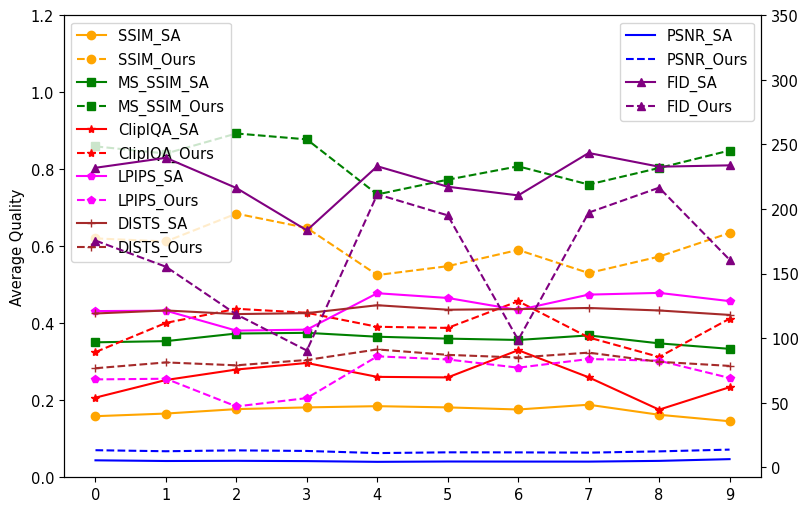

In [6]:
# Set the global font to be Times New Roman, 10.5pt size
# 设置图像的大小
plt.rcParams['figure.figsize'] = (9, 6) 
# 设置字体大小
plt.rcParams['font.size'] = 10.5  
# 设置字体
#plt.rcParams['font.family'] = ['serif']
#plt.rcParams['font.serif'] = ['SunTimes']
plt.rcParams['font.sans-serif'] = 'Times New Roman' # 设置全局字体，会被局部字体顶替
#plt.rcParams['font.family'] = 'Times New Roman'  


fig, ax1 = plt.subplots()  # figsize参数已经在plt.rcParams['figure.figsize']中设置，这里不需要再设置

ax2 = ax1.twinx()
ax2.plot(list(average_quality.keys()), [quality['psnr1'] for quality in average_quality.values()], '-',  color='blue',label='PSNR_SA')
ax2.plot(list(average_quality.keys()), [quality['psnr2'] for quality in average_quality.values()], '--',  color='blue',label='PSNR_Ours')

ax1.plot(list(average_quality.keys()), [quality['ssim1'] for quality in average_quality.values()], '-o', color='orange', label='SSIM_SA')
ax1.plot(list(average_quality.keys()), [quality['ssim2'] for quality in average_quality.values()], '--o', color='orange', label='SSIM_Ours')

ax1.plot(list(average_quality.keys()), [quality['ms_ssim1'] for quality in average_quality.values()], '-s', color='green', label='MS_SSIM_SA')
ax1.plot(list(average_quality.keys()), [quality['ms_ssim2'] for quality in average_quality.values()], '--s', color='green', label='MS_SSIM_Ours')

ax1.plot(list(average_quality.keys()), [quality['clip_iqa1'] for quality in average_quality.values()], '-*', color='red', label='ClipIQA_SA')
ax1.plot(list(average_quality.keys()), [quality['clip_iqa2'] for quality in average_quality.values()], '--*', color='red', label='ClipIQA_Ours')

ax2.plot(list(average_quality.keys()), [quality['fid1'] for quality in average_quality.values()], '-^', color='purple', label='FID_SA')
ax2.plot(list(average_quality.keys()), [quality['fid2'] for quality in average_quality.values()], '--^', color='purple', label='FID_Ours')

ax1.plot(list(average_quality.keys()), [quality['lpips1'] for quality in average_quality.values()], '-p', color='magenta', label='LPIPS_SA')
ax1.plot(list(average_quality.keys()), [quality['lpips2'] for quality in average_quality.values()], '--p', color='magenta', label='LPIPS_Ours')

ax1.plot(list(average_quality.keys()), [quality['dists1'] for quality in average_quality.values()], '-+', color='brown', label='DISTS_SA')
ax1.plot(list(average_quality.keys()), [quality['dists2'] for quality in average_quality.values()], '--+', color='brown', label='DISTS_Ours')

# Add labels to the y-axes
ax1.set_ylabel('Average Quality')
# Add a legend
ax1.legend(loc='upper left', fontsize='10.5')
ax2.legend(loc='upper right', fontsize='10.5')

ax1.set_yticks(np.arange(0, 1.4, 0.2))  # Set y-ticks for ax1
ax2.set_yticks(np.arange(0, 400, 50))  # Set y-ticks for ax2
ax1.set_xticks(np.arange(0, 10))

plt.savefig('my_figure.pdf', dpi=500)
plt.savefig('my_figure.png', dpi=500)
plt.show()